<a href="https://colab.research.google.com/github/MaheshGouru/CS5265-Assignment-5/blob/main/employee_churn_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning using scikit-learn**

As a reminder, below are the following best practices we should follow when performing Machine Learning in Python:

1. Perform all pre-processing steps within cross-validation
2. Measure model performance (and model selection) using cross-validation
3. Follow literate programming practices to make code readable and make collaboration easier

## Problem Formulation

In this example, we will use IBM's HR Attrition dataset, available here: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset.
The dataset contains data on 1470 employees. The variables covered in this dataset focus heavily on demographic attributes (e.g. gender, age and race), social related attributes (e.g. marital status) and work related attributes (e.g. tenure and pay).

In [18]:
#tables and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Load Data

Here we first load the data into python using pandas and read it in as a pandas dataframe which is the format which we will use throughout the example. 

In [3]:
employee_df = pd.read_excel('/content/IBM-HR-Data-Employee-Attrition.xlsx')
display(employee_df.head())
employee_df.info()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [4]:
employee_df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

## Data cleaning and EDA

We can now briefly explore our data. For now, we can observe that there are a zero NA values which will likely need imputation. We'll wait for this step so that we can put it within our training loop in case future data sets from IBM HR might have NA values. You are welcome to explore additional aspects of the data and build out 2-3 features on your own

In [5]:
employee_df = employee_df.dropna(subset=['Attrition'])
employee_df.shape

(1470, 35)

In [7]:
class_column = 'Attrition'
random_seed = 2435

X_train, X_test, y_train, y_test = train_test_split(employee_df.drop(columns=class_column), employee_df[class_column],
                                                   test_size=0.25, random_state=random_seed, stratify=employee_df[class_column])

Quick sanity check to make sure that everything seems correct:

In [8]:
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (1102, 34)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1331,48,Travel_Rarely,1224,Research & Development,10,3,Life Sciences,1,1867,4,...,4,80,0,29,3,3,22,10,12,9
485,27,Travel_Rarely,798,Research & Development,6,4,Medical,1,655,1,...,3,80,2,6,5,2,5,3,0,3
1368,34,Travel_Frequently,735,Research & Development,22,4,Other,1,1932,3,...,2,80,0,16,3,3,15,10,6,11
579,34,Travel_Rarely,121,Research & Development,2,4,Medical,1,804,3,...,3,80,0,6,3,3,6,5,1,3
142,38,Travel_Rarely,364,Research & Development,3,5,Technical Degree,1,193,4,...,2,80,0,19,2,3,3,2,2,2



On X test: 
X test dimensions:  (368, 34)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
129,49,Travel_Rarely,470,Research & Development,20,4,Medical,1,170,3,...,3,80,0,16,2,2,15,11,5,11
1120,38,Travel_Rarely,437,Sales,16,3,Life Sciences,1,1583,2,...,2,80,0,8,5,4,3,2,1,2
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,...,3,80,0,8,3,3,8,7,3,0
965,25,Travel_Rarely,882,Research & Development,19,1,Medical,1,1358,4,...,3,80,3,7,6,2,3,2,1,2
94,32,Travel_Rarely,1093,Sales,6,4,Medical,1,125,2,...,1,80,0,12,0,3,11,8,5,7


In [9]:
# X Train
print('On y train: ')
print('y train dimensions: ', y_train.shape)
display(y_train.head())

# X test
print('\nOn y test: ')
print('y test dimensions: ', y_test.shape)
display(y_test.head())

On y train: 
y train dimensions:  (1102,)


1331    No
485     No
1368    No
579     No
142     No
Name: Attrition, dtype: object


On y test: 
y test dimensions:  (368,)


129     No
1120    No
3       No
965     No
94      No
Name: Attrition, dtype: object

## Establish the training pipeline

We can now establish the training pipeline for our models. Since this is a process we would need to repeat several times, it's good to essentially functionalize the process so we do not need to re-write redundant code. Here, we can impute some values that were missing, and encode any categorical values. Note that these pipelines will change according to the model and methodology you choose - additionally, the pipelines will also change depending on the data types of the columns in your dataset. 

In [10]:
# TODO: establish your own pipelines for the different data types

cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder())])

num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(strategy='mean')),
                               ('scale_num', StandardScaler())])

In [11]:
# TODO: establish your preprocessing pipeline by your feature set

categorical_features = X_train.select_dtypes(include="object").columns
integer_features = employee_df.select_dtypes(exclude="object").columns

# preproc

preproc = ColumnTransformer([('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object)),
                             ('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number))],
                             remainder='passthrough')

print(preproc)


ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_pipe',
                                 Pipeline(steps=[('cat_impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot_cat',
                                                  OneHotEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9c6a7e750>),
                                ('num_pipe',
                                 Pipeline(steps=[('impute_num',
                                                  SimpleImputer()),
                                                 ('scale_num',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9c6a7e7d0>)])


In [15]:
# TODO: set up your modeling pipeline
# Modeling pipeline for Logistic Regresion
log_pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])

# Feel free to uncomment and edit the code below to visualize your overall pieline
with config_context(display='diagram'):
     display(log_pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9c6a7e750>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9c6a7e7d0>)])),
                ('mdl',
                 LogisticRegression(penalty='elasticnet', solver='saga',
                                    tol=0.01))])

In [16]:
# TODO: set up your modeling pipeline
# Modeling pipeline for Random Forest Classifer
rfc_pipe = Pipeline(steps=[('preproc', preproc),('classifier',RandomForestClassifier())])

# Feel free to uncomment and edit the code below to visualize your overall pieline
with config_context(display='diagram'):
     display(rfc_pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9c6a7e750>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9c6a7e7d0>)])),
                ('classifier', RandomForestClassifier())])

In [19]:
# TODO: set up your modeling pipeline
# Modeling pipeline for Gradient Boosting Model
gradient_pipe = Pipeline(steps=[('preproc', preproc),('classifier',GradientBoostingClassifier())])

# Feel free to uncomment and edit the code below to visualize your overall pieline
with config_context(display='diagram'):
     display(gradient_pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9c6a7e750>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9c6a7e7d0>)])),
                ('classifier', GradientBoostingClassifier())])

## Cross-validation with hyperparameter tuning

Now that we have our pipelines, we can now use this as part of cross validation and hyperparameter tuning.

In [20]:
# TODO: set up your tuning grid
# Tuning grid for Logistic Regression
log_tuning_grid = {
    'mdl__l1_ratio' : np.linspace(0,1,5),
    'mdl__C': np.logspace(-1, 6, 3) 
}

print(log_tuning_grid)

{'mdl__l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ]), 'mdl__C': array([1.00000000e-01, 3.16227766e+02, 1.00000000e+06])}


In [21]:
# TODO: set up your tuning grid
# Tuning grid for Random Forest Classifer
rfc_tuning_grid = { 
    'classifier__n_estimators': [510, 30, 50, 100],
    'classifier__max_depth': [1,3,5]
}

print(rfc_tuning_grid)

{'classifier__n_estimators': [510, 30, 50, 100], 'classifier__max_depth': [1, 3, 5]}


In [22]:
# TODO: set up your tuning grid
# Tuning grid for Gradient Boosting Classifer  
gradient_tuning_grid = { 
    'classifier__n_estimators': [10,20,50,100],
    'classifier__max_depth': [1,3,5]
}

print(gradient_tuning_grid)

{'classifier__n_estimators': [10, 20, 50, 100], 'classifier__max_depth': [1, 3, 5]}


In [24]:
# TODO: fit your model
# GridSearch for Logistic Regression
log_grid_search = GridSearchCV(log_pipe, cv = 5, param_grid = log_tuning_grid, return_train_score=True)
log_grid_search.fit(X_train, y_train.values.ravel())
log_best = log_grid_search.best_params_
log_result = pd.DataFrame(log_grid_search.cv_results_)


In [25]:
# TODO: fit your model
# GridSearch for Random Forest Classifer
rfc_grid_search = GridSearchCV(rfc_pipe, cv = 5, param_grid = rfc_tuning_grid, return_train_score=True)
rfc_grid_search.fit(X_train, y_train.values.ravel())
rfc_best = rfc_grid_search.best_params_
rfc_result = pd.DataFrame(rfc_grid_search.cv_results_)

In [26]:
# TODO: fit your model
# GridSearch for Gradient Boost Model
gradient_grid_search = GridSearchCV(gradient_pipe, cv = 5, param_grid = gradient_tuning_grid, return_train_score=True)
gradient_grid_search.fit(X_train, y_train.values.ravel())
gradient_best = gradient_grid_search.best_params_
gradient_result = pd.DataFrame(gradient_grid_search.cv_results_)

In [ ]:
# TODO: find the best performing model parameters and their values




## Final fit

The final fit here is already present in the generated model due to the way we set our parameters in the grid search. If we want to look at the performance, we can do so. Here is a non-helpful description of the best model:

In [27]:
# TODO: print your best estimator (pipeline)
print(log_best)
print(rfc_best)
print(gradient_best)

{'mdl__C': 0.1, 'mdl__l1_ratio': 0.0}
{'classifier__max_depth': 5, 'classifier__n_estimators': 510}
{'classifier__max_depth': 5, 'classifier__n_estimators': 50}


## Variable importance

Now we assess the importance in the selected model to reveal any potential insights.

In [ ]:
# TODO: feel free to print out the target classes
# ??

In [28]:
# TODO: feel free to uncomment and edit the code below to obtain your feature weights

log_vip = log_grid_search.best_estimator_['mdl'].coef_[0]
log_vip

array([-0.51274206,  0.37733676, -0.15063066,  0.00584792, -0.36594162,
        0.07405774,  0.0735253 , -0.27842013,  0.05909946, -0.17985081,
       -0.22183859,  0.26144881, -0.29879299,  0.01275703, -0.2469708 ,
        0.05088782,  0.36500907, -0.04763291, -0.19779292, -0.13847984,
       -0.2314647 , -0.0387545 ,  0.19916282, -0.31874557, -0.30466955,
        0.33737916, -0.28603596, -0.91748451,  0.63144855, -0.27473354,
       -0.15671249,  0.29661756,  0.00537751,  0.        , -0.05347152,
       -0.31324384,  0.00842303, -0.3081183 , -0.29353451, -0.3491134 ,
       -0.1543475 , -0.01251539,  0.33663209, -0.04207098, -0.03762429,
       -0.2044748 ,  0.        , -0.15150043, -0.09907925, -0.20526113,
       -0.28174442,  0.28709592, -0.38105041,  0.49870372, -0.48229616])

In [30]:
# TODO: feel free to uncomment and edit the code below to obtain your feature weights

rfc_vip = rfc_grid_search.best_estimator_['classifier']
rfc_vip

RandomForestClassifier(max_depth=5, n_estimators=510)

In [31]:
# TODO: feel free to uncomment and edit the code below to obtain your feature weights

gradient_vip = gradient_grid_search.best_estimator_['classifier']
gradient_vip

GradientBoostingClassifier(max_depth=5, n_estimators=50)

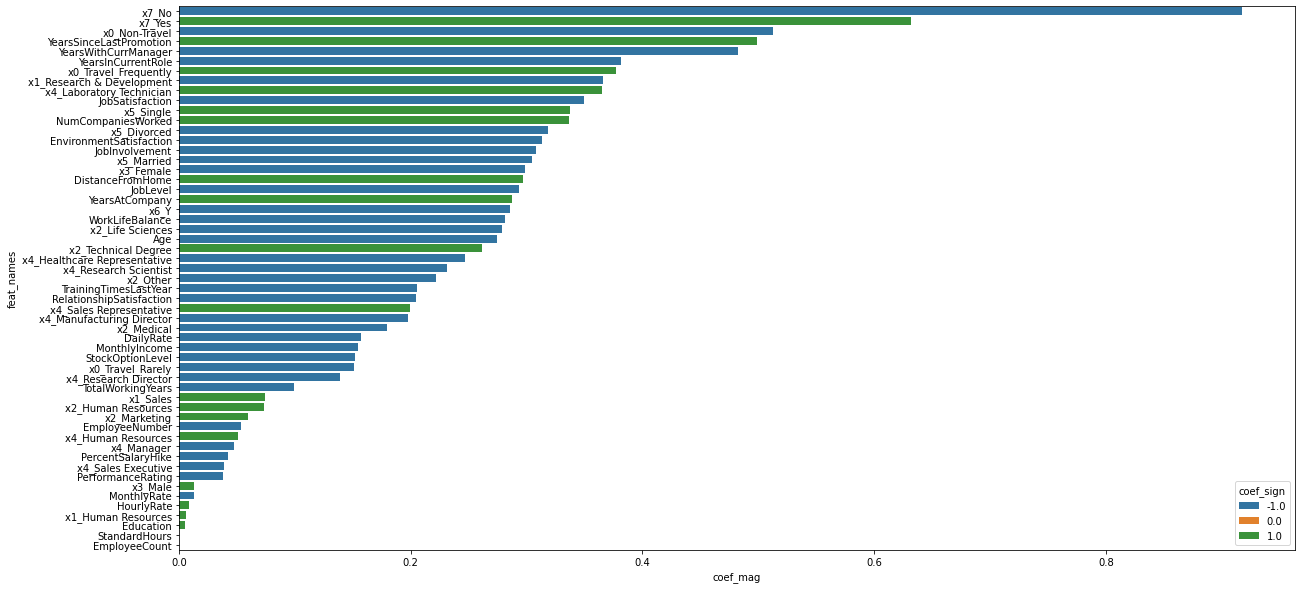

In [33]:
# TODO: feel free to uncomment and edit the code below to obtain your feature importance graph. 
# Did the graph surprise you? What features did you think were more important?
# Response: The graph did not surprise me as I would have guessed that pivotal 
# features like years since last promotion would dictate whether employees could
# interview elsewhere to rise in seniority quicker rather than stagnate in their 
# role.
# #get names in correct preproc order
cat_names = log_grid_search.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names()
num_names = log_grid_search.best_estimator_.named_steps['preproc'].transformers_[1][2]

# #create df with vip info
coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'log_vip': log_vip})

# #get sign and magnitude information
coef_info = coef_info.assign(coef_mag = abs(coef_info['log_vip']), coef_sign = np.sign(coef_info['log_vip']))

# #sort and plot
coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
plt.figure(figsize = (20,10))
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False)

In [36]:
# TODO: feel free to uncomment and edit the code below to obtain your feature importance graph. 
# Did the graph surprise you? What features did you think were more important?

# #get names in correct preproc order
rfc_cat_names = rfc_grid_search.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names()
rfc_num_names = rfc_grid_search.best_estimator_.named_steps['preproc'].transformers_[1][2]

# #create df with vip info
coef_info = pd.DataFrame({'feat_names':np.hstack([rfc_cat_names, rfc_num_names]), 'rfc_vip': rfc_vip})

# #get sign and magnitude information
coef_info = coef_info.assign(coef_mag = abs(coef_info['rfc_vip']), coef_sign = np.sign(coef_info['rfc_vip']))

# #sort and plot
coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
plt.figure(figsize = (20,10))
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False)

ValueError: ignored

In [ ]:
# TODO: feel free to uncomment and edit the code below to obtain your feature importance graph. 
# Did the graph surprise you? What features did you think were more important?

# #get names in correct preproc order
cat_names = gradient_grid_search.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names()
num_names = gradient_grid_search.best_estimator_.named_steps['preproc'].transformers_[1][2]

# #create df with vip info
coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'gradient_vip': gradient_vip})

# #get sign and magnitude information
coef_info = coef_info.assign(coef_mag = abs(coef_info['gradient_vip']), coef_sign = np.sign(coef_info['gradient_vip']))

# #sort and plot
coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
plt.figure(figsize = (20,10))
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False)

## Performance metrics on test data


Here, we can see the performance of the model, which is pretty nice! We can also look into different scores specifically for more insight into the performance.

In [40]:
# TODO: print your classification report of your model

log_result = (classification_report(y_test, log_grid_search.best_estimator_.predict(X_test)))
print(log_result)

rfc_result = (classification_report(y_test, rfc_grid_search.best_estimator_.predict(X_test)))
print(rfc_result)

gradient_result = (classification_report(y_test, gradient_grid_search.best_estimator_.predict(X_test)))
print(gradient_result)

              precision    recall  f1-score   support

          No       0.91      0.98      0.94       309
         Yes       0.82      0.47      0.60        59

    accuracy                           0.90       368
   macro avg       0.87      0.73      0.77       368
weighted avg       0.89      0.90      0.89       368

              precision    recall  f1-score   support

          No       0.85      0.99      0.91       309
         Yes       0.60      0.10      0.17        59

    accuracy                           0.85       368
   macro avg       0.73      0.54      0.54       368
weighted avg       0.81      0.85      0.80       368

              precision    recall  f1-score   support

          No       0.88      0.96      0.92       309
         Yes       0.61      0.32      0.42        59

    accuracy                           0.86       368
   macro avg       0.75      0.64      0.67       368
weighted avg       0.84      0.86      0.84       368



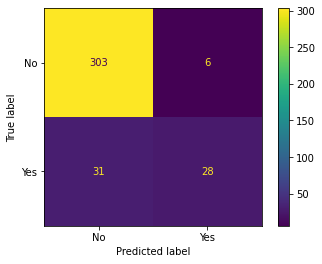

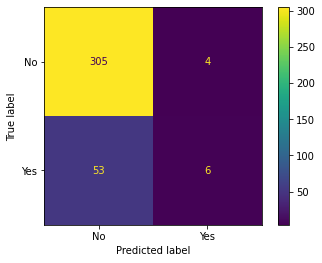

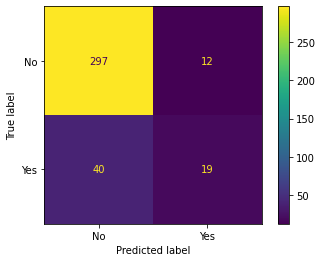

In [39]:
# TODO: plot the confusion matrix graph

log_cm = confusion_matrix(y_test, log_grid_search.best_estimator_.predict(X_test))
log_display = ConfusionMatrixDisplay(confusion_matrix=log_cm,
                               display_labels=log_grid_search.classes_)
log_display.plot()

rfc_cm = confusion_matrix(y_test, rfc_grid_search.best_estimator_.predict(X_test))
rfc_display = ConfusionMatrixDisplay(confusion_matrix=rfc_cm,
                               display_labels=rfc_grid_search.classes_)
rfc_display.plot()

gradient_cm = confusion_matrix(y_test, gradient_grid_search.best_estimator_.predict(X_test))
gradient_display = ConfusionMatrixDisplay(confusion_matrix=gradient_cm,
                               display_labels=gradient_grid_search.classes_)
gradient_display.plot()

plt.show()

**Extra Credit [5 points]** Calculate the financial value of your models based on the following costs and benefits
* Leave being True class and Stay being False

* Cost of replacing an employee is $120,000 (RC)

* Cost of intervention $2,000 used on each employee predicted to leave (IC)

* Intervention success rate is 20% (SR)

|                 | Actual Leave | Actual Stay |
|:---------------:|:------------:|:-----------:|
| Predicted Leave |      TP      |      FP     |
|  Predicted Stay |      FN      |      TN     |
 
* Compare models on value, find best model according to value metric


# **Financial Value of each model**

* Logistic Regression: \$120,000 * 28 <sub>(TP)</sub> * (.20) - \$2,000 * 34 <sub>(TP+FP)</sub> = \$604K

* Random Forest: \$120,000 * 6 <sub>(TP)</sub> * (.20) - \$2,000 * 10 <sub>(TP+FP)</sub> = \$124k

* Gradient Descent: \$120000 * 19 <sub>(TP)</sub> * (.20) - \$2,000 * 31 <sub>(TP+FP)</sub> = \$394k

**Logistic Regression is the optimal at +$478k**